In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1U459t2CYLmMaQXJ-_anmtQN35mQVQVuS/Data Augmentation-XrayImg


# 0. Import Libs

In [4]:
# !unzip large_dataset.zip
!nvidia-smi


Mon May 10 03:11:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/{cu_version}/{torch_version}/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/{cu_version}/{torch_version}/index.html
     |████████████████████████████████| 286kB 15.9MB/s 
     |████████████████████████████████| 194kB 27.3MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.3-cp37-cp37m-linux_x86_64.whl size=24568972 sha256=154462d5be627a902677dd2eff241ced4c445819766a17016add75ce88f74793
  Stored in directory: /root/.cache/pip/wheels/57/2a/55/762bce3ae6e1ef4eee0419cefa3229a6d30892e058345629f4
Successfully built mmcv-full


In [9]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirements/build.txt
!pip install -v -e .
!mkdir checkpoints/ 

Cloning into 'mmdetection'...
remote: Enumerating objects: 17548, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17548 (delta 10), reused 12 (delta 5), pack-reused 17523
Receiving objects: 100% (17548/17548), 21.16 MiB | 8.22 MiB/s, done.
Resolving deltas: 100% (12208/12208), done.
Checking out files: 100% (989/989), done.
/content/gdrive/.shortcut-targets-by-id/1U459t2CYLmMaQXJ-_anmtQN35mQVQVuS/Data Augmentation-XrayImg/mmdetection
Created temporary directory: /tmp/pip-ephem-wheel-cache-8r_egkf1
Created temporary directory: /tmp/pip-req-tracker-cy85oct8
Created requirements tracker '/tmp/pip-req-tracker-cy85oct8'
Created temporary directory: /tmp/pip-install-z__lrbb2
Obtaining file:///content/gdrive/.shortcut-targets-by-id/1U459t2CYLmMaQXJ-_anmtQN35mQVQVuS/Data%20Augmentation-XrayImg/mmdetection
  Added file:///content/gdrive/.shortcut-targets-by-id/1U459t2CYLmMaQXJ-_anmtQN35mQVQVuS/Data%20Augmentation-XrayImg/mmdetec

In [10]:
%cd mmdetection/

[Errno 2] No such file or directory: 'mmdetection/'
/content/gdrive/.shortcut-targets-by-id/1U459t2CYLmMaQXJ-_anmtQN35mQVQVuS/Data Augmentation-XrayImg/mmdetection


In [4]:
import torch
from torch.utils.data import Dataset
import os
import glob
import cv2
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import mmcv
#from mmdet.apis import init_detector, inference_detector
import numpy as np 
from sklearn.model_selection import train_test_split

In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 1. Utils

In [ ]:
def get_anno(txt_path):
    annos=[]
    with open(txt_path) as f:
      for line in f.readlines():
        anno=line[:-1].split(" ")
        anno = [float(num) for num in anno]
        annos.append(anno[1:])
    return annos


def get_offset(annos,image): # for single image
  new_annos=[]
  for annotation in annos:
    bbox = [annotation[0] * image.shape[1], annotation[1] * image.shape[0], 
            annotation[2] * image.shape[1], annotation[3] * image.shape[0]]
    new_annos.append(bbox)
  return new_annos


def get_path(data_path,test_size):
  img_paths = glob.glob(os.path.join(data_path,"*.png"))
  
  def split(img_paths):
    dic={}
    for img_path in img_paths:
      txt_path = img_path.replace('.png','.txt')
      dic[img_path]=get_anno(txt_path)
    return dic
    
  f = int(len(img_paths)*test_size)
  return split(img_paths[f:]),split(img_paths[:f])

In [ ]:
# Predict label: [0 cx cy w h]
def my_draw(img_path,anno):
  image=cv2.imread(img_path)
  print(image.shape)
  bboxs=get_offset(anno,image)
  for bbox in bboxs:
    cv2.rectangle(image, (int(bbox[0] - bbox[2] / 2), int(bbox[1] - bbox[3] / 2)), (int(bbox[0] + bbox[2] / 2), int(bbox[1] + bbox[3] / 2)), (225, 0, 0), 2)
  plt.figure(figsize = (10, 10))
  plt.imshow(image)

def read_json(path):
  with open(path,'r') as f:
    data = json.load(f)
  return data

def write_json(dic,path):
  with open(path,'w') as f:
    json.dump(dic,f,indent=4)

In [ ]:
data_path = '../val_clahe'
dic_train,dic_test=get_path(data_path,0.2)

In [ ]:
write_json(dic_train,'../large_train_data.json')
write_json(dic_test,'../large_test_data.json')

(512, 192, 3)


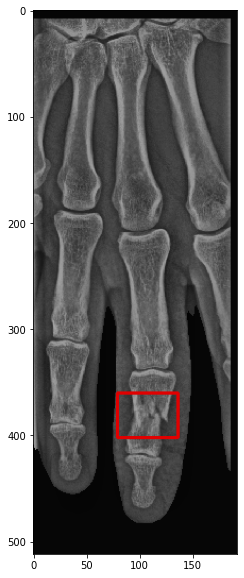

In [ ]:
test_dic=read_json('../large_test_data.json')
item=next(iter(test_dic.items()))
my_draw(item[0],item[1])

# 2. Convert2 COCO

In [ ]:
import cv2
import json 

def convert_coco(path,out_file):
  dic=read_json(path)
  coco_dic={}
  coco_dic['info'] = {'year': '2021', 'version': '2', 'description': 'MANH', 'contributor': '', 'url': '/bone-xray-images/', 'date_created': '2021-04-08T13:18:41+00:00'}
  coco_dic['licenses'] = [{'id': 1, 'url': '/bone-xray-images/', 'name': 'Unknown'}]
  images = []
  annotations = []
  h = 0
  for i,(k,v) in enumerate(dic.items()):
    img=cv2.imread(k)
    image = {
      "id": i,
      'license':1,
      "file_name": k.split('/')[-1],
      "height": img.shape[0], # height of img
      "width": img.shape[1], # width of img
      'date_captured':'2021-04-08T13:18:41+00:00',
    }
    images.append(image)

    bbxs=get_offset(v,img)  # [ [x_c,y_c,width,height] , [ bbx2 ], [bbx3]  ]
    for j,bbx in enumerate(bbxs):
      data_bbx = {
          'id': h,
          'image_id':i,
          'category_id':1,
          'bbox':[int(bbx[0] - bbx[2] / 2), int(bbx[1] - bbx[3] / 2),int(bbx[2]),int(bbx[3])],  
          'area': int(bbx[2] * bbx[3]),
          "segmentation": [],
          "iscrowd": 0,
      }
      annotations.append(data_bbx)
      h += 1

  coco_dic['categories'] = [{'id': 0, 'name': 'Bone-Fracture', 'supercategory': 'none'}, {'id': 1, 'name': '0', 'supercategory': 'Bone-Fracture'}]
  coco_dic['images'] = images
  coco_dic['annotations'] = annotations
  write_json(coco_dic,out_file)
  

In [ ]:
convert_coco('../large_train_data.json','../large_train_data_coco.json')
convert_coco('../large_test_data.json','../large_test_data_coco.json')

In [ ]:
data = read_json('../large_test_data_coco.json')
print(data['annotations'])

[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [79, 360, 57, 41], 'area': 2393, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [79, 360, 45, 35], 'area': 1619, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 2, 'category_id': 1, 'bbox': [72, 415, 48, 38], 'area': 1862, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 3, 'category_id': 1, 'bbox': [241, 326, 43, 46], 'area': 1978, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 4, 'category_id': 1, 'bbox': [204, 174, 41, 72], 'area': 2952, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 5, 'category_id': 1, 'bbox': [148, 397, 42, 38], 'area': 1596, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 6, 'category_id': 1, 'bbox': [111, 116, 47, 38], 'area': 1786, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 7, 'category_id': 1, 'bbox': [165, 135, 44, 64], 'area': 2879, 'segmentation': [], 'iscrowd': 0}, {'id': 8, 'image_id': 8, 'category_id': 1,

In [ ]:
!wget -P ./checkpoints/ http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth

--2021-05-08 23:29:33--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291065 (160M) [application/octet-stream]
Saving to: ‘./checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth’

faster_rcnn_r50_caf 100%[===================>] 159.54M  9.24MB/s    in 20s     

2021-05-08 23:29:54 (8.16 MB/s) - ‘./checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth’ saved [167291065/167291065]



In [ ]:
!ls

checkpoints  docs	     pytest.ini       requirements.txt	tests
configs      LICENSE	     README.md	      resources		tools
demo	     mmdet	     README_zh-CN.md  setup.cfg		work_dirs
docker	     mmdet.egg-info  requirements     setup.py


In [ ]:
!ls ../
!python3 ./tools/train.py ../train_xray.py

 balloon		      large_test_data.json	   original.zip
 balloon_dataset.zip	      large_train_data_coco.json   README.roboflow.txt
 best_val.pth		      large_train_data.json	   Segmentation.ipynb
 checkpoints		      latest.pth		   SUB_MURA.ipynb
'Data Augmentation-XrayImg'   __MACOSX			   test_data.json
 data.json		      mask_rcnn_balloon.h5	   train_balloon.py
 Deeplabv3+mm.ipynb	      mmdetection		   train_data.json
 Deeplabv3_Resnet101.ipynb    mmdetection_HMM		   train_shortcut
 dog.jpg		      mmdetection_HMMm		   train_xray.py
 e2e_mm.ipynb		      mmdetection.ipynb		   train_xray_segm.py
 faster_RCNN_MM.ipynb	      mmdetection_old		   val_clahe
 Large_Dataset_Faster.ipynb   mmsegmentation		   XRAYBoneDataset
 large_dataset.zip	      original			   XRAYBoneDataset.zip
 large_test_data_coco.json   'original+flip+rotate(45)'
2021-05-10 03:50:21,599 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.10 (default,

|1.| original | 0.989(50) | 0.670(50-95)| epoch 27|
|2.| medium after clahe | 0.977| 0.621 | epoch 45 |


In [ ]:
config_file = '../train_xray.py'
checkpoint_file = './work_dirs/train_xray/latest.pth'
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
img_paths=list(test_dic.keys()) # 326 anh
for path in img_paths:
  result=inference_detector(model, path)
  img=cv2.imread(path)
  plt.figure(figsize=(20,20))
  plt.imshow(model.show_result(img, result))
  plt.show()